# Notebook TITANIC AutoML avec Azure ML


Notebook Python Azure ML pour la modélisation automatique (AUTOML) de la survie des passagers du Titanic.
<br><br>
https://www.kaggle.com/c/titanic
<br><br>
Données : 
https://www.kaggle.com/c/titanic/data

<img src="https://kwmp.ca/wp-content/uploads/2018/04/titanic-the-musical-1024x538.jpg">

 ## Description des variables :
 - PassengerId: and id given to each traveler on the boat
 - Pclass: the passenger class. It has three possible values: 1,2,3 (first, second and third class)
 - The Name of the passeger
 - The Sex
 - The Age
 - SibSp: number of siblings and spouses traveling with the passenger
 - Parch: number of parents and children traveling with the passenger
 - The ticket number
 - The ticket Fare
 - The cabin number
 - The embarkation. This describe three possible areas of the Titanic from which the people embark. Three possible values S,C,Q

> https://www.kaggle.com/c/titanic

### 0. Paramétrage

In [1]:
import sys
sys.version

'3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) \n[GCC 7.3.0]'

In [2]:
import datetime
now = datetime.datetime.now()
print(now)

2020-06-01 12:02:20.837880


In [3]:
import azureml.core
print("Version Azure ML Service :", azureml.core.VERSION)

Version Azure ML Service : 1.6.0


In [4]:
import os

subscription_id = os.environ.get("SUBSCRIPTION_ID", "A RENSEIGNER")
resource_group = os.environ.get("RESOURCE_GROUP", "titanicworkspaceRG")
workspace_name = os.environ.get("WORKSPACE_NAME", "Titanicworkspace")

In [5]:
from azureml.core import Workspace

try:
   ws = Workspace(subscription_id = subscription_id, resource_group = resource_group, workspace_name = workspace_name)
   ws.write_config()
   print("Le workspace Azure ML service a été trouvé : OK")
except:
   print("Le workspace Azure ML service n'a pas été trouvé")

Le workspace Azure ML service a été trouvé : OK


In [6]:
import pandas as pd
import numpy as np
import pandas.io.sql as pd_sql

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun

import logging
import os
import random

## 1. Chargement des données

In [7]:
import azureml.dataprep as dprep

In [8]:
pd.set_option('display.max_columns', None)

titanic_path = "https://raw.githubusercontent.com/retkowsky/titanic/master/train.csv"

print("Retrieving data:")
print(titanic_path)

titanic_df = dprep.read_csv(path=titanic_path, header=dprep.PromoteHeadersMode.GROUPED)

display(titanic_df.head(5))

Retrieving data:
https://raw.githubusercontent.com/retkowsky/titanic/master/train.csv


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.925,None,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.05,None,S


In [9]:
all_columns = dprep.ColumnSelector(term=".*", use_regex=True)

drop_if_all_null = [all_columns, dprep.ColumnRelationship(dprep.ColumnRelationship.ALL)]

useful_columns = [
    "PassengerId", "Survived", "Pclass", "Sex", "Age", "SibSp",
    "Fare", "Embarked"
]

tmp_df = (titanic_df
    .replace_na(columns=all_columns)
    .drop_nulls(*drop_if_all_null)
    .rename_columns(column_pairs={
        "PassengerId": "PassengerId",
        "Survived": "Survived",
        "Pclass": "Pclass",
        "Sex": "Sex",
        "Age": "Age",
        "SibSp": "SibSp",
        "Fare": "Fare",
        "Embarked": "Embarked",
     })
    .keep_columns(columns=useful_columns))
tmp_df.head(5)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Fare,Embarked
0,1,0,3,male,22,1,7.25,S
1,2,1,1,female,38,1,71.2833,C
2,3,1,3,female,26,0,7.925,S
3,4,1,1,female,35,1,53.1,S
4,5,0,3,male,35,0,8.05,S


In [10]:
decimal_type = dprep.TypeConverter(data_type=dprep.FieldType.DECIMAL)
profile = tmp_df.set_column_types(type_conversions={
    "Age": decimal_type,
    "Fare": decimal_type
}).get_profile()

In [11]:
profile

,Type,Min,Max,Count,Missing Count,Not Missing Count,Percent Missing,Error Count,Empty Count,Unique Values,0.1% Quantile (est.),1% Quantile (est.),5% Quantile (est.),25% Quantile (est.),50% Quantile (est.),75% Quantile (est.),95% Quantile (est.),99% Quantile (est.),99.9% Quantile (est.),Mean,Standard Deviation,Variance,Skewness,Kurtosis,WhiskerTop,WhiskerBottom
PassengerId,FieldType.STRING,1,99,891.0,0.0,891.0,0.000000,0.0,0.0,891,,,,,,,,,,,,,,,,
Survived,FieldType.STRING,0,1,891.0,0.0,891.0,0.000000,0.0,0.0,2,,,,,,,,,,,,,,,,
Pclass,FieldType.STRING,1,3,891.0,0.0,891.0,0.000000,0.0,0.0,3,,,,,,,,,,,,,,,,
Sex,FieldType.STRING,female,male,891.0,0.0,891.0,0.000000,0.0,0.0,2,,,,,,,,,,,,,,,,
Age,FieldType.DECIMAL,0.42,80,891.0,177.0,714.0,0.198653,0.0,0.0,89,0.4735,13.5111,12.6667,20.28,28,38.2,56.3067,67.44,78.716,29.6991,14.5265,211.019,0.387474,0.159767,65,0.42
SibSp,FieldType.STRING,0,8,891.0,0.0,891.0,0.000000,0.0,0.0,7,,,,,,,,,,,,,,,,
Fare,FieldType.DECIMAL,0,512.329,891.0,0.0,891.0,0.000000,0.0,0.0,248,0,7.54406,7.5156,7.90776,14.456,31.066,112.451,255.394,512.329,32.2042,49.6934,2469.44,4.77121,33.1231,63.3433,0
Embarked,FieldType.STRING,C,S,891.0,2.0,889.0,0.002245,0.0,0.0,4,,,,,,,,,,,,,,,,


In [12]:
url="https://raw.githubusercontent.com/retkowsky/titanic/master/train.csv"
df=pd.read_csv(url, index_col=None, na_values=['NA'])

In [13]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [14]:
# Suppression valeurs manquantes
df = df.dropna()

In [15]:
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [16]:
# Nombre de col et de lignes
df.shape

(183, 12)

In [17]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [18]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [19]:
# Suppression de colonnes
df = df.drop(['Cabin','Parch'],axis=1)

In [20]:
df.head(20)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Ticket,Fare,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,PC 17599,71.2833,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,113803,53.1000,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,17463,51.8625,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,PP 9549,16.7000,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,113783,26.5500,S
21,22,1,2,"Beesley, Mr. Lawrence",male,34.0,0,248698,13.0000,S
23,24,1,1,"Sloper, Mr. William Thompson",male,28.0,0,113788,35.5000,S
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,19950,263.0000,S
52,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,PC 17572,76.7292,C
54,55,0,1,"Ostby, Mr. Engelhart Cornelius",male,65.0,0,113509,61.9792,C


## 2. Analyses exploratoires

In [21]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Fare
count,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000
mean,455.366120,0.672131,1.191257,35.674426,0.464481,78.682469
std,247.052476,0.470725,0.515187,15.643866,0.644159,76.347843
min,2.000000,0.000000,1.000000,0.920000,0.000000,0.000000
25%,263.500000,0.000000,1.000000,24.000000,0.000000,29.700000
50%,457.000000,1.000000,1.000000,36.000000,0.000000,57.000000
75%,676.000000,1.000000,1.000000,47.500000,1.000000,90.000000
max,890.000000,1.000000,3.000000,80.000000,3.000000,512.329200


In [22]:
df.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Fare
PassengerId,1.000000,0.148495,-0.089136,0.030933,-0.083488,0.029740
Survived,0.148495,1.000000,-0.034542,-0.254085,0.106346,0.134241
Pclass,-0.089136,-0.034542,1.000000,-0.306514,-0.103592,-0.315235
Age,0.030933,-0.254085,-0.306514,1.000000,-0.156162,-0.092424
SibSp,-0.083488,0.106346,-0.103592,-0.156162,1.000000,0.286433
Fare,0.029740,0.134241,-0.315235,-0.092424,0.286433,1.000000


## 3. Modélisation AutoML avec Azure ML service

<img src="https://blog.cellenza.com/wp-content/uploads/2018/11/automl.png">

In [23]:
col_target=['Survived']
col_train=['Age','Pclass','Sex','Fare','SibSp','Embarked']
X=df[col_train]
y=df[col_target]

In [24]:
X.describe()

,Age,Pclass,Fare,SibSp
count,183.000000,183.000000,183.000000,183.000000
mean,35.674426,1.191257,78.682469,0.464481
std,15.643866,0.515187,76.347843,0.644159
min,0.920000,1.000000,0.000000,0.000000
25%,24.000000,1.000000,29.700000,0.000000
50%,36.000000,1.000000,57.000000,0.000000
75%,47.500000,1.000000,90.000000,1.000000
max,80.000000,3.000000,512.329200,3.000000


In [25]:
dic = {'male':0,'female':1}
X['Sex']=X['Sex'].apply(lambda x:dic[x])

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### 3.1 Partitionnement des données

In [26]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3, random_state=10)

In [27]:
print(X.shape)

(183, 6)


In [28]:
print(X_train.shape)

(128, 6)


In [29]:
print(X_test.shape)

(55, 6)


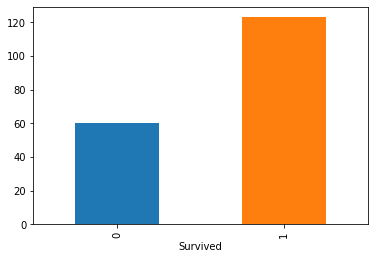

In [30]:
df.groupby('Survived').size().plot(kind='bar')

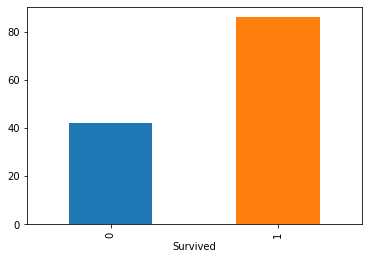

In [31]:
# Sur le Training
y_train.groupby('Survived').size().plot(kind='bar')

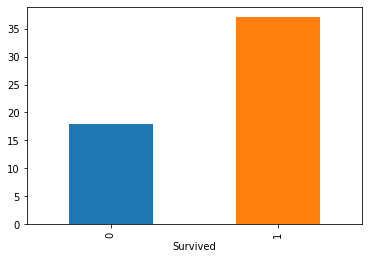

In [32]:
# Sur le test
y_test.groupby('Survived').size().plot(kind='bar')

### 3.2 Connexion workspace Azure ML service

In [33]:
ws = Workspace.from_config()

experiment_name = 'AutoMLTitanicSDK'

project_folder = './sample_projects/automltitanicsdk'

In [34]:
experiment = Experiment(ws, experiment_name)

output = {}
output['Version Azure ML service'] = azureml.core.VERSION
output['Workspace Name'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
pd.DataFrame(data = output, index = ['']).T

,
Version Azure ML service,1.6.0
Workspace Name,Titanicworkspace
Resource Group,titanicworkspaceRG
Location,westeurope
Project Directory,./sample_projects/automltitanicsdk
Experiment Name,AutoMLTitanicSDK


### 3.3 AutoML avec Azure ML service

### Les principes de l'autoML

 https://docs.microsoft.com/en-us/azure/machine-learning/service/concept-automated-ml

### Aide en ligne AutoML avec Azure ML service

https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-configure-auto-train

### Paramétrage AutoML

In [36]:
automl_settings = {
    "iteration_timeout_minutes" : 5,
    "experiment_timeout_minutes" : 60,
    "iterations" : 100,                  
    "primary_metric" : 'AUC_weighted',
    "enable_early_stopping" : "True",
    "verbosity" : logging.INFO,
    "enable_voting_ensemble":"False",     # Pas de voting
    "enable_stack_ensemble":"False"       # Pas d'ensemble
    }

In [37]:
from azureml.train.automl import AutoMLConfig

automated_ml_config = AutoMLConfig(task = 'classification',
                             debug_log = 'automated_ml_errors.log',
                             path = project_folder,
                             model_explainability=True, # Explanibility du meilleur modèle
                             X = X_train.values,
                             y = y_train.values.flatten(),
                             X_valid = X_test.values,
                             y_valid = y_test.values.flatten(),
                             **automl_settings)

WARNING - The AutoMLConfig parameters, X and y, will soon be deprecated. Please refer to our documentation for the latest interface: https://aka.ms/AutoMLConfig


> Liste des modèles disponibles : https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-configure-auto-train

### Exécution de la recherche du meilleur modèle via Azure ML AutoML

In [38]:
from azureml.core.experiment import Experiment
experiment=Experiment(ws, experiment_name)
local_run = experiment.submit(automated_ml_config, show_output=True)

Running on local machine
Parent Run ID: AutoML_bd3f3500-4812-419b-bd51-3a351624f43c

Current status: DatasetEvaluation. Gathering dataset statistics.
Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetFeaturization. Beginning to fit featurizers and featurize the dataset.
Current status: DatasetFeaturizationCompleted. Completed fit featurizers and featurizing the dataset.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Class balancing detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and all classes are balanced in your training data.
              Learn more about imbalanced data: https://aka.ms/AutomatedMLImbalancedData

TYPE:         Missing feature values imputation
STATUS:       PASSED
DESCRIPTION:  No feature missing values were detected in the training data.
              Learn more about missing value imputation: https://aka.ms

### Visualisation des itérations depuis le portail Azure :

In [39]:
local_run

Experiment,Id,Type,Status,Details Page,Docs Page
AutoMLTitanicSDK,AutoML_bd3f3500-4812-419b-bd51-3a351624f43c,automl,Completed,Link to Azure Machine Learning studio,Link to Documentation


### Widget AutoML

In [40]:
from azureml.widgets import RunDetails
RunDetails(local_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

### 3.4 Liste des résultats autoML

In [41]:
children = list(local_run.get_children())
metricslist = {}
for run in children:
    properties = run.get_properties()
    metrics = {k: v for k, v in run.get_metrics().items() if isinstance(v, float)}
    metricslist[int(properties['iteration'])] = metrics

rundata = pd.DataFrame(metricslist).sort_index(1)
rundata

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
AUC_macro,0.83,0.89,0.84,0.85,0.87,0.84,0.89,0.81,0.82,0.88,0.87,0.88,0.88,0.83,0.89,0.86,0.89,0.86,0.86,0.84,0.77,0.81,0.87,0.89,0.81,0.69,0.79,0.84,0.86,0.88,0.69,0.83,0.85,0.81
AUC_micro,0.87,0.90,0.86,0.87,0.87,0.86,0.89,0.84,0.84,0.88,0.88,0.88,0.88,0.85,0.88,0.86,0.88,0.87,0.88,0.82,0.80,0.81,0.88,0.89,0.81,0.76,0.83,0.87,0.85,0.89,0.77,0.86,0.86,0.83
AUC_weighted,0.83,0.89,0.84,0.85,0.87,0.84,0.89,0.81,0.82,0.88,0.87,0.88,0.88,0.83,0.89,0.86,0.89,0.86,0.86,0.84,0.77,0.81,0.87,0.89,0.81,0.69,0.79,0.84,0.86,0.88,0.69,0.83,0.85,0.81
accuracy,0.78,0.82,0.76,0.78,0.73,0.73,0.75,0.67,0.78,0.76,0.73,0.75,0.73,0.80,0.82,0.73,0.76,0.76,0.75,0.67,0.73,0.67,0.75,0.76,0.67,0.67,0.76,0.76,0.78,0.76,0.71,0.76,0.78,0.75
average_precision_score_macro,0.83,0.88,0.83,0.84,0.85,0.83,0.87,0.80,0.80,0.88,0.85,0.85,0.87,0.83,0.82,0.81,0.88,0.84,0.83,0.84,0.74,0.72,0.86,0.87,0.75,0.72,0.78,0.84,0.83,0.87,0.70,0.81,0.84,0.78
average_precision_score_micro,0.87,0.90,0.88,0.88,0.88,0.88,0.90,0.86,0.86,0.90,0.89,0.90,0.89,0.86,0.89,0.86,0.89,0.88,0.90,0.84,0.80,0.80,0.89,0.90,0.83,0.73,0.85,0.88,0.84,0.90,0.75,0.87,0.87,0.84
average_precision_score_weighted,0.86,0.90,0.86,0.87,0.88,0.86,0.90,0.84,0.84,0.90,0.88,0.89,0.89,0.86,0.87,0.86,0.90,0.87,0.87,0.87,0.79,0.77,0.89,0.90,0.81,0.74,0.82,0.87,0.86,0.89,0.74,0.85,0.87,0.83
balanced_accuracy,0.71,0.74,0.70,0.70,0.78,0.65,0.65,0.63,0.68,0.81,0.75,0.64,0.78,0.69,0.78,0.75,0.81,0.70,0.74,0.50,0.70,0.50,0.81,0.68,0.50,0.50,0.67,0.67,0.67,0.67,0.60,0.67,0.68,0.71
f1_score_macro,0.72,0.76,0.71,0.71,0.72,0.66,0.66,0.63,0.70,0.76,0.72,0.65,0.72,0.72,0.79,0.72,0.76,0.71,0.73,0.40,0.69,0.40,0.74,0.70,0.40,0.40,0.68,0.68,0.68,0.68,0.60,0.68,0.70,0.71
f1_score_micro,0.78,0.82,0.76,0.78,0.73,0.73,0.75,0.67,0.78,0.76,0.73,0.75,0.73,0.80,0.82,0.73,0.76,0.76,0.75,0.67,0.73,0.67,0.75,0.76,0.67,0.67,0.76,0.76,0.78,0.76,0.71,0.76,0.78,0.75


### 3.5 Choix du meilleur modèle selon l'AUC

In [42]:
best_run, fitted_model = local_run.get_output()

print("Meilleur modèle selon l'AUC :")
print("")
print(best_run)
print("")
print(fitted_model)

Meilleur modèle selon l'AUC :

Run(Experiment: AutoMLTitanicSDK,
Id: AutoML_bd3f3500-4812-419b-bd51-3a351624f43c_23,
Type: None,
Status: Completed)

Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
        feature_sweeping_config=None, feature_sweeping_timeout=None,
        featurization_config=None, force_text_dnn=None,
        is_cross_validation=None, is_onnx_compatible=None, logger=None,
        obser...max_iter=1000, multi_class='ovr', penalty='l2', random_state=None,
         tol=0.0001, verbose=0))])


In [43]:
fitted_model.get_params

<bound method Pipeline.get_params of Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
        feature_sweeping_config=None, feature_sweeping_timeout=None,
        featurization_config=None, force_text_dnn=None,
        is_cross_validation=None, is_onnx_compatible=None, logger=None,
        obser...max_iter=1000, multi_class='ovr', penalty='l2', random_state=None,
         tol=0.0001, verbose=0))])>

In [44]:
fitted_model.steps

[('datatransformer',
  DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
          feature_sweeping_config=None, feature_sweeping_timeout=None,
          featurization_config=None, force_text_dnn=None,
          is_cross_validation=None, is_onnx_compatible=None, logger=None,
          observer=None, task=None, working_dir=None)),
 ('TruncatedSVDWrapper',
  TruncatedSVDWrapper(n_components=0.8510526315789474, random_state=None)),
 ('LinearSVMWrapper',
  LinearSVMWrapper(C=0.040949150623804234, class_weight=None, dual=True,
           fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
           max_iter=1000, multi_class='ovr', penalty='l2', random_state=None,
           tol=0.0001, verbose=0))]

### 3.6 Changement métrique de qualité

Autres métriques disponibles :
accuracy, AUC_weighted, average_precision_score_weighted, norm_macro_recall, precision_score_weighted

In [45]:
lookup_metric = "f1_score_weighted"

best_run, fitted_model = local_run.get_output(metric = lookup_metric)

print("Meilleur modèle selon le score F1 :")
print("")
print(best_run)
print("")
print(fitted_model)

Meilleur modèle selon le score F1 :

Run(Experiment: AutoMLTitanicSDK,
Id: AutoML_bd3f3500-4812-419b-bd51-3a351624f43c_14,
Type: None,
Status: Completed)

Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
        feature_sweeping_config=None, feature_sweeping_timeout=None,
        featurization_config=None, force_text_dnn=None,
        is_cross_validation=None, is_onnx_compatible=None, logger=None,
        obser...8947, silent=True, subsample=1,
          subsample_for_bin=200000, subsample_freq=0, verbose=-10))])


In [46]:
lookup_metric = "accuracy"

best_run, fitted_model = local_run.get_output(metric = lookup_metric)

print("Meilleur modèle selon accuracy :")
print("")
print(best_run)
print("")
print(fitted_model)

Meilleur modèle selon accuracy :

Run(Experiment: AutoMLTitanicSDK,
Id: AutoML_bd3f3500-4812-419b-bd51-3a351624f43c_14,
Type: None,
Status: Completed)

Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
        feature_sweeping_config=None, feature_sweeping_timeout=None,
        featurization_config=None, force_text_dnn=None,
        is_cross_validation=None, is_onnx_compatible=None, logger=None,
        obser...8947, silent=True, subsample=1,
          subsample_for_bin=200000, subsample_freq=0, verbose=-10))])


### 3.7 Choix d'une itération particulière

In [47]:
moniteration = 10

In [49]:
my_run, my_model = local_run.get_output(iteration = moniteration)

print("Pipeline "+ str(moniteration) +"ème itération :")
print("")
print(my_run)
print("")
print(my_model)

Pipeline 10ème itération :

Run(Experiment: AutoMLTitanicSDK,
Id: AutoML_bd3f3500-4812-419b-bd51-3a351624f43c_10,
Type: None,
Status: Completed)

Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
        feature_sweeping_config=None, feature_sweeping_timeout=None,
        featurization_config=None, force_text_dnn=None,
        is_cross_validation=None, is_onnx_compatible=None, logger=None,
        obser...       n_jobs=1, penalty='l2', power_t=0.7777777777777777,
           random_state=None, tol=0.01))])


### 4. On applique le modèle sur la base de Test

### 4.1 On utilise le meilleur modèle selon l'AUC

In [50]:
best_run, fitted_model = local_run.get_output()

print("Meilleur modèle selon la métrique initiale :")
print("")
print(best_run)
print("")
print(fitted_model)

Meilleur modèle selon la métrique initiale :

Run(Experiment: AutoMLTitanicSDK,
Id: AutoML_bd3f3500-4812-419b-bd51-3a351624f43c_23,
Type: None,
Status: Completed)

Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
        feature_sweeping_config=None, feature_sweeping_timeout=None,
        featurization_config=None, force_text_dnn=None,
        is_cross_validation=None, is_onnx_compatible=None, logger=None,
        obser...max_iter=1000, multi_class='ovr', penalty='l2', random_state=None,
         tol=0.0001, verbose=0))])


In [52]:
best_run, fitted_model = local_run.get_output()
print(best_run)
print()
print(fitted_model)
print()
best_run_metrics = best_run.get_metrics()
for metric_name in best_run_metrics:
    metric = best_run_metrics[metric_name]
    print(metric_name, ' = ', metric)

Run(Experiment: AutoMLTitanicSDK,
Id: AutoML_bd3f3500-4812-419b-bd51-3a351624f43c_23,
Type: None,
Status: Completed)

Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
        feature_sweeping_config=None, feature_sweeping_timeout=None,
        featurization_config=None, force_text_dnn=None,
        is_cross_validation=None, is_onnx_compatible=None, logger=None,
        obser...max_iter=1000, multi_class='ovr', penalty='l2', random_state=None,
         tol=0.0001, verbose=0))])

accuracy_table  =  aml://artifactId/ExperimentRun/dcid.AutoML_bd3f3500-4812-419b-bd51-3a351624f43c_23/accuracy_table
confusion_matrix  =  aml://artifactId/ExperimentRun/dcid.AutoML_bd3f3500-4812-419b-bd51-3a351624f43c_23/confusion_matrix
precision_score_macro  =  0.75
recall_score_weighted  =  0.7636363636363637
matthews_correlation  =  0.4262413420606707
average_precision_score_micro  =  0.9025670298361648
f1_score_micro  =  0.7636363636363637


In [53]:
from azureml.core import Model

best_run.register_model(model_path='outputs/model.pkl', model_name='Titanic-model',
                        tags={'Training context':'Azure Auto ML SDK'},
                        properties={'AUC': best_run_metrics['AUC_weighted'], 'Accuracy': best_run_metrics['accuracy']})


Model(workspace=Workspace.create(name='Titanicworkspace', subscription_id='70b8f39e-8863-49f7-b6ba-34a80799550c', resource_group='titanicworkspaceRG'), name=Titanic-model, id=Titanic-model:5, version=5, tags={'Training context': 'Azure Auto ML SDK'}, properties={'AUC': '0.8918918918918918', 'Accuracy': '0.7636363636363637'})

In [54]:
# Liste des modèles référencés
for model in Model.list(ws):
    print(model.name, 'version =', model.version)
    for tag_name in model.tags:
        tag = model.tags[tag_name]
        print ('\t',tag_name, ':', tag)
    for prop_name in model.properties:
        prop = model.properties[prop_name]
        print ('\t',prop_name, ':', prop)
    print('\n')

Titanic-model version = 5
	 Training context : Azure Auto ML SDK
	 AUC : 0.8918918918918918
	 Accuracy : 0.7636363636363637


Titanic-model version = 4
	 Training context : Azure Auto ML SDK
	 AUC : 0.9166666666666667
	 Accuracy : 0.6727272727272727


Titanic-model version = 3
	 Training context : Azure Auto ML SDK
	 AUC : 0.9129129129129129
	 Accuracy : 0.8


Titanic-model version = 2
	 Training context : Azure Auto ML SDK
	 AUC : 0.8948948948948948
	 Accuracy : 0.7818181818181819


amlstudio-titanic-real-time-in version = 2
	 CreatedByAMLStudio : true


Titanic-model version = 1
	 Training context : Azure Auto ML
	 AUC : 0.924174174174174
	 Accuracy : 0.8181818181818182




### 4.2 On applique le modèle

In [55]:
# Calcul de la décision
y_test_pred = fitted_model.predict(X_test.values)

In [56]:
Decision=pd.DataFrame(y_test_pred)

In [57]:
# Obtention des scores
proba=fitted_model.predict_proba(X_test.values)

In [58]:
Decision.columns = ['Decision']
Decision.head()

,Decision
0,1
1,1
2,0
3,1
4,1


In [59]:
Proba=pd.DataFrame(proba)

In [60]:
Proba.columns = ['Proba_0', 'Proba_1']

In [61]:
Proba.head()

,Proba_0,Proba_1
0,0.01,0.99
1,0.01,0.99
2,0.82,0.18
3,0.01,0.99
4,0.01,0.99


In [62]:
Scoring = pd.concat([Decision, Proba], axis=1)

### 4.3 Résultats du scoring

In [63]:
Scoring.head()

,Decision,Proba_0,Proba_1
0,1,0.01,0.99
1,1,0.01,0.99
2,0,0.82,0.18
3,1,0.01,0.99
4,1,0.01,0.99


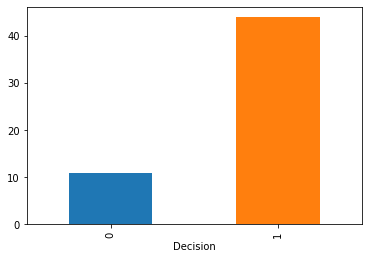

In [64]:
Scoring.groupby('Decision').size().plot(kind='bar')

In [65]:
Scoring.describe()

,Decision,Proba_0,Proba_1
count,55.00,55.00,55.00
mean,0.80,0.26,0.74
std,0.40,0.27,0.27
min,0.00,0.00,0.15
25%,1.00,0.01,0.54
50%,1.00,0.12,0.88
75%,1.00,0.46,0.99
max,1.00,0.85,1.00


### 4.4 Exportation des scores dans un fichier CSV

In [66]:
import time
datedujour = time.strftime("%Y-%m-%d-%H%M%S")

In [68]:
# Export
Scoring.to_csv(r'Export_Titanic'+datedujour+'.csv')

In [72]:
# Visualisation des fichiers
%ls Export*.csv -ls

3 -rwxrwxrwx 1 root root 2432 Jun  1 12:20 Export_Titanic2020-06-01-121958.csv*


In [74]:
#Visu du fichier
with open(os.path.join('./Export_Titanic2020-06-01-121958.csv'), 'r') as f:
    print(f.read())

,Decision,Proba_0,Proba_1
0,1,0.005932055752593035,0.994067944247407
1,1,0.007458038897284691,0.9925419611027153
2,0,0.824470839346719,0.175529160653281
3,1,0.009993974347283108,0.9900060256527169
4,1,0.011255125258306964,0.988744874741693
5,1,0.025685343777958614,0.9743146562220414
6,1,0.3421704101271261,0.6578295898728739
7,0,0.8525288441103004,0.14747115588969964
8,0,0.7614013890399889,0.2385986109600111
9,1,0.07631438098471965,0.9236856190152803
10,1,0.46007409763540863,0.5399259023645914
11,1,0.010046108539623733,0.9899538914603763
12,0,0.6065639251351231,0.39343607486487686
13,0,0.5911537072598121,0.4088462927401879
14,1,0.00999659556117427,0.9900034044388257
15,1,0.37475094977976176,0.6252490502202382
16,1,0.31879579853242423,0.6812042014675758
17,1,0.08306532258136157,0.9169346774186384
18,1,0.021689606520512994,0.978310393479487
19,1,0.011921120183495115,0.9880788798165049
20,1,0.18408559830669724,0.8159144016933028
21,1,0.006038381467742493,0.9939616185322575
22,1,0.239956388

> Fin